# Agent-Based Dynamic Slot Filling

- Author: [Jongcheol Kim](https://github.com/greencode-99)
- Design: 
- Peer Review: [kofsitho87](https://github.com/kofsitho87), [Heeah Kim](https://github.com/yellowGangneng) 
- This is a part of [LangChain Open Tutorial](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/19-Cookbook/07-Agent/17-Agent-BasedDynamicSlotFilling.ipynb) [![Open in GitHub](https://img.shields.io/badge/Open%20in%20GitHub-181717?style=flat-square&logo=github&logoColor=white)](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/19-Cookbook/07-Agent/17-Agent-BasedDynamicSlotFilling.ipynb)

## Overview

This tutorial explains how to implement an **Agent-based Dynamic Slot Filling** system. It covers the process of creating an intelligent conversational system that analyzes user requests to automatically collect necessary information and supplements missing information through dialogue.


The system can handle various tasks such as restaurant reservations, meeting scheduling, hotel bookings, and flight reservations, dynamically collecting and validating the required information for each task.


### Features

- **Dynamic Slot Filling**: Automatically identifies and collects necessary information by analyzing user requests


- **Multi-task Support**: Handles various tasks including restaurant, meeting, hotel, and flight reservations


- **Conversational Information Collection**: Supplements missing information through natural dialogue


- **Information Validation**: Automatically validates the input information


### Graph of Agent-Based Dynamic Slot Filling

This graph shows the workflow of an Agent-based Dynamic Slot Filling system:

- **Start → Classify**  
    - Analyzes user requests and classifies task type

- **Initialize Slots**
    - Sets up required information fields

- **Extract Slots**
    - Extracts necessary information from user messages
    - Identifies missing information

- **Generate Response**
    - Requests additional information or completes task
    - Ends when all information is collected

The system iterates through conversation with the user until all necessary information is gathered.

![Agent-Based-Dynamic-Slot-Filling](./assets/17-agent-based-dynamic-slot-filling-graph.png)

### Table of Contents

- [Overview](#overview)
- [Environment Setup](#environment-setup)
- [Constants and Prompt Template Definition](#constants-and-prompt-template-definition)
- [State Management](#state-management)
- [Graph Construction](#graph-construction)
- [Create Reservation Agent Graph](#create-reservation-agent-graph)
- [Example Execution](#example-execution)

### References

- [LangGraph: Quickstart](https://langchain-ai.github.io/langgraph/tutorials/introduction/)
- [LLM Slot Filling](https://github.com/ujhrkzy/llm-slot-filling)

## Environment Setup

Set up the environment. You may refer to [Environment Setup](https://wikidocs.net/257836) for more details.

**[Note]**
- `langchain-opentutorial` is a package that provides a set of easy-to-use environment setup, useful functions and utilities for tutorials. 
- You can checkout the [`langchain-opentutorial`](https://github.com/LangChain-OpenTutorial/langchain-opentutorial-pypi) for more details.

In [1]:
%%capture --no-stderr
%pip install langchain-opentutorial

In [2]:
# Install required packages
from langchain_opentutorial import package

package.install(
    [
        "langsmith",
        "langchain",
        "langchain_core",
        "langchain_openai",
        "langgraph",
    ],
    verbose=False,
    upgrade=False,
)


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [3]:
# Set environment variables
from langchain_opentutorial import set_env

set_env(
    {
        "OPENAI_API_KEY": "",
        "LANGCHAIN_API_KEY": "",
        "LANGCHAIN_TRACING_V2": "true",
        "LANGCHAIN_ENDPOINT": "https://api.smith.langchain.com",
        "LANGCHAIN_PROJECT": "Agent-Based-Dynamic-Slot-Filling",
    }
)

Environment variables have been set successfully.


You can alternatively set API keys such as `OPENAI_API_KEY` in a `.env` file and load them.

[Note] This is not necessary if you've already set the required API keys in previous steps.

In [4]:
# Load API keys from .env file
from dotenv import load_dotenv

load_dotenv(override=True)

True

## Constants and Prompt Template Definition

Constants is defined as below:
- `TASK_SLOTS` : Defines the required information for each task type
- `TASK_RULES` : Defines the rules for information collection for each task type
- `TASK_EXAMPLES` : Provides examples of user requests for each task type
- `TASK_CLASSIFICATION_TEMPLATE` : A prompt template for classifying the user's request into a task
- `SLOT_EXTRACTION_TEMPLATE` : A prompt template for extracting information from the user's message
- `RESPONSE_TEMPLATE` : A prompt template for generating a response to the user's message


### Task Slots

**Task Slots** is a structure that defines the required information for each task type. Each task has its own unique set of slots, allowing systematic collection of necessary information.

In [5]:
TASK_SLOTS = {
    "restaurant": {
        "restaurant_address": "Restaurant Address/Location (City name)",
        "number_of_people": "Number of People (numeric)",
        "reservation_datetime": "Reservation Date and Time (YYYY/MM/DD HH:MM format)",
    },
    "meeting": {
        "meeting_datetime": "Meeting Date and Time (YYYY/MM/DD HH:MM format)",
        "platform": "Video Conference Platform (zoom/teams/google meet)",
        "meeting_duration": "Meeting Duration (in minutes)",
    },
    "hotel": {
        "hotel_location": "Hotel Location (City name)",
        "check_in_date": "Check-in Date (YYYY/MM/DD)",
        "check_out_date": "Check-out Date (YYYY/MM/DD)",
        "room_type": "Room Type (single/double/suite)",
        "number_of_guests": "Number of Guests (numeric)",
    },
    "flight": {
        "departure_city": "Departure City",
        "arrival_city": "Arrival City",
        "departure_date": "Departure Date (YYYY/MM/DD HH:MM format)",
        "return_date": "Return Date (YYYY/MM/DD HH:MM format)",
        "passenger_count": "Number of Passengers (numeric)",
        "seat_class": "Seat Class (economy/business/first)",
    },
}

### Task Rules

Defines the rules to follow when collecting information for each task type. These rules serve as guidelines that the conversational agent references when gathering information through user interactions.


- **Restaurant Reservation**: Collect information about location, number of people, and reservation date/time


- **Hotel Booking**: Collect information about location, check-in/out dates, room type, and number of guests


- **Meeting Room Reservation**: Collect information about location, number of attendees, meeting date/time, and duration


- **Flight Reservation**: Collect information about departure/arrival locations, departure/return dates, and number of passengers

In [6]:
TASK_RULES = {
    "restaurant": """
    1. Do not ask for information that has already been provided
    2. First confirm the specific restaurant location (city name)
    3. Accept only numeric values for the number of people
    4. Accept reservation date and time in YYYY/MM/DD HH:MM format""",
    "hotel": """
    1. Do not ask for information that has already been provided
    2. First confirm the hotel location (city name)
    3. Accept check-in/check-out dates in YYYY/MM/DD format
    4. Have users select room type from: single/double/suite
    5. Accept only numeric values for the number of guests""",
    "meeting": """
    1. Do not ask for information that has already been provided
    2. First confirm the meeting room location
    3. Accept only numeric values for the number of attendees
    4. Accept meeting date and time in YYYY/MM/DD HH:MM format
    5. Accept meeting duration in hours (e.g., 1 hour, 2 hours)""",
    "flight": """
    1. Do not ask for information that has already been provided
    2. First confirm departure and arrival locations
    3. Accept departure and return dates in YYYY/MM/DD HH:MM format
    4. Accept only numeric values for the number of passengers""",
}

In [7]:
TASK_EXAMPLES = {
    "restaurant": "I'd like to make a dinner reservation for 4 people next Friday at 7 PM",
    "hotel": "I want to book a suite room in Manhattan, New York from the 1st to the 3rd of next month",
    "meeting": "I'm planning to have a one-hour meeting tomorrow at 2 PM in the Downtown conference room",
    "flight": "I'd like to book 2 economy seats from LAX to New York at 10 AM on the 15th of next month",
}

### Task Classification Template

Defines the prompt template for classifying the user's request into a task.
- `user_message` : The user's message to be analyzed
- `task_type` : The type of task selected by the agent
- `confidence` : The confidence score of the task classification (0.0 ~ 1.0)

In [8]:
TASK_CLASSIFICATION_TEMPLATE = """Please analyze the user's message and select the appropriate task for reservation/booking.

    Available task list:
    - restaurant: Restaurant Reservation
    - meeting: Video Conference Booking
    - hotel: Hotel Reservation
    - flight: Flight Booking

    User message:
    {user_message}

    Please respond in the following format:
    {{"task": "task_name", "confidence": 0.XX}}

    confidence should be a value between 0.0 and 1.0, indicating the certainty of intent classification.
    If the intent cannot be determined, set confidence to 0.
    """

### Slot Extraction Template

Defines the prompt template for extracting information from the user's message.
- `task_type` : The type of task for which information is being extracted
- `required_slots` : The slots that need to be extracted
- `slots` : The current state of the slots
- `messages` : The conversation history
- `last_message` : The last message from the user


Please follow these rules strictly:
1. Date and Time Conversion Rules:
   - All dates must be in **YYYY/MM/DD HH:MM** format8
   - If only "next week" is mentioned, ask for specific date and time (keep as **null** )
   - Convert to date only when day of week is specified (e.g., "next Monday")
   - If no time is specified, keep as **null**


2. Incomplete Date/Time Cases:
   - "Next week" only → **null** 
   - "Evening" only → **null** 
   - "Next Monday evening" → **YYYY/MM/DD 19:00** 
   - "Tomorrow lunch" → **YYYY/MM/DD 12:00** 


3. Numbers must be converted to numeric format (e.g., "four people" → **4** )
4. Use location names as is (e.g., "Manhattan", "New York")
5. Mark uncertain information as **null** 

In [9]:
SLOT_EXTRACTION_TEMPLATE = """Please extract information related to {task_type} reservation from the following conversation.

Required Information:
{required_slots}

Current Slot Status:
{slots}

Conversation:
{messages}

Last Message:
{last_message}

Current Date: {current_date}

Please follow these rules strictly:
1. Date and Time Conversion Rules:
   - All dates must be in YYYY/MM/DD HH:MM format
   - If only "next week" is mentioned, ask for specific date and time (keep as null)
   - Convert to date only when day of week is specified (e.g., "next Monday")
   - If no time is specified, keep as null

2. Incomplete Date/Time Cases:
   - "Next week" only → null
   - "Evening" only → null
   - "Next Monday evening" → YYYY/MM/DD 19:00
   - "Tomorrow lunch" → YYYY/MM/DD 12:00

3. Numbers must be converted to numeric format (e.g., "four people" → "4")
4. Use location names as is (e.g., "Manhattan", "New York")
5. Mark uncertain information as null

Please respond with extracted information in the following JSON format:
{{"restaurant_address": "location or null",
  "number_of_people": "number or null",
  "reservation_datetime": "YYYY/MM/DD HH:MM or null"}}
"""

### Response Template

Defines the prompt template for collecting missing information through natural dialogue.
- `task_type` : The type of task for which information is being collected
- `required_slots` : The slots that need to be collected
- `slots` : The current state of the slots
- `messages` : The conversation history
- `last_message` : The last message from the user


Please follow these rules:
- `task_rules`: The rules specific to the current task type
- Respond in a natural, conversational manner

In [10]:
RESPONSE_TEMPLATE = """Continue the conversation in a friendly tone while collecting missing information.

Reservation Type: {task_type}
Required Information:
{required_slots}

Current Slot Status:
{slots}

Conversation History:
{messages}

Please follow these rules:
{task_rules}

Respond in a natural, conversational manner."""

In [11]:
from langchain_core.prompts import ChatPromptTemplate

slot_extraction_prompt = ChatPromptTemplate.from_template(SLOT_EXTRACTION_TEMPLATE)
response_prompt = ChatPromptTemplate.from_template(RESPONSE_TEMPLATE)

## State Management

State management plays a crucial role in controlling the flow of the conversation and tracking necessary information.
Defines the `SupervisorState` class to manage the state of the conversational agent.
Inherits from `TypedDict` to define and track the state of the conversational agent.
This state management allows maintaining the conversation context with the user and sequentially collecting necessary information.


### SupervisorState
- `messages` : Manages conversation history
- `task_type` : Tracks current task type
- `confidence` : Task classification confidence score
- `slots` : Stores collected information
- `current_slot` : Currently processing slot
- `completed` : Task completion status
- `stage` : Current stage ('classify' or 'slot_filling')

In [12]:
from typing import TypedDict
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import HumanMessage, AIMessage
from datetime import datetime


class SupervisorState(TypedDict):
    """Supervisor State for managing the state of the entire system"""

    messages: list[HumanMessage | AIMessage]
    task_type: str | None
    confidence: float
    slots: dict
    current_slot: str | None
    completed: bool
    stage: str

## Graph Construction

Uses LangGraph's `StateGraph` to construct the conversation flow.


### Main Nodes
- `classify_task`: Classifies the task type based on the user's message
    - Identifies reservation/booking intent from user message to select appropriate task
    - Proceeds to slot initialization or information extraction based on selected task


- `initialize_slots`: Initializes slots for user message
    - Initializes required slots based on selected task
    - Stores initialized slot state in state variables


- `extract_slots`: Extracts necessary information from user message
    - Uses `LLM` to extract structured information from natural language
    - Validates extracted information
    - Updates with new information while maintaining existing slot values


- `generate_response`: Generates appropriate response based on current state
    - Branches response based on task classification confidence
    - Requests missing information
    - Generates reservation completion message
    

- `should_continue`: Controls conversation flow by determining next step based on:
    - Checks user input waiting status
    - Branches based on task classification confidence
    - Checks if slot initialization is needed
    - Determines whether to continue information extraction

In [13]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate
import json


def classify_task(state: SupervisorState) -> SupervisorState:
    """Performs task classification."""
    print("\n=== Task Classification ===")
    llm = ChatOpenAI(temperature=0)
    chain = PromptTemplate.from_template(TASK_CLASSIFICATION_TEMPLATE) | llm

    message = state["messages"][-1].content
    result = chain.invoke({"user_message": message})
    classification = json.loads(result.content)

    state["task_type"] = classification["task"]
    state["confidence"] = classification["confidence"]
    state["stage"] = (
        "slot_filling" if classification["confidence"] >= 0.5 else "classify"
    )

    print(f"Classified Task: {state['task_type']}")
    print(f"Confidence: {state['confidence']:.2f}")
    return state

In [14]:
def initialize_slots(state: SupervisorState) -> SupervisorState:
    """Initializes slots based on task type."""
    print("\n=== Initializing Slots ===")
    if state["task_type"]:
        state["slots"] = {
            slot: "null" for slot in TASK_SLOTS[state["task_type"]].keys()
        }
        print(f"Initialized Slots: {state['slots']}")
    return state

In [15]:
def extract_slots(state: SupervisorState) -> SupervisorState:
    """Extracts slot information from the conversation."""
    print("\n=== Extracting Slot Information ===")

    try:
        llm = ChatOpenAI(temperature=0)
        required_slots = "\n".join(
            [f"- {k}: {v}" for k, v in TASK_SLOTS[state["task_type"]].items()]
        )
        messages_text = "\n".join(msg.content for msg in state["messages"])
        last_message = state["messages"][-1].content
        current_date = datetime.now().strftime("%Y/%m/%d")

        chain = slot_extraction_prompt | llm

        result = chain.invoke(
            {
                "task_type": state["task_type"],
                "required_slots": required_slots,
                "slots": json.dumps(state["slots"], ensure_ascii=False),
                "messages": messages_text,
                "last_message": last_message,
                "current_date": current_date,
            }
        )

        try:
            new_slots = json.loads(result.content)

            for slot, value in new_slots.items():
                if (
                    value is not None
                    and str(value).lower() != "null"
                    and str(value).strip()
                ):
                    state["slots"][slot] = value

            print("\n=== Current Slot Status ===")
            print(f"Task Type: {state['task_type']}")
            for slot, value in state["slots"].items():
                print(f"{TASK_SLOTS[state['task_type']][slot]}: {value}")
            print("=====================\n")

        except json.JSONDecodeError:
            print("Error parsing slot information.")

    except Exception as e:
        print(f"Error extracting slot information: {str(e)}")

    return state

In [16]:
def generate_response(state: SupervisorState) -> SupervisorState:
    """Generates response based on current state."""
    print("\n=== Generating Response ===")

    response = ""
    if state["stage"] == "classify" and state["confidence"] < 0.5:
        response = "Sorry, I couldn't determine which type of reservation you're looking for.\n"
        response += "The following reservations are possible:\n"
        for task in TASK_SLOTS.keys():
            response += f"- {task}\n"
        response += (
            "\nPlease specify the reservation you're looking for in more detail."
        )
    else:
        empty_slots = []
        for slot, value in state["slots"].items():
            if value is None or str(value).lower() == "null" or not str(value).strip():
                empty_slots.append(slot)

        if empty_slots:
            task_type = state["task_type"]
            response = "Could you please provide the following information:\n"
            for slot in empty_slots:
                response += f"- {TASK_SLOTS[task_type][slot]}\n"
        else:
            response = (
                "All information has been entered. I will complete the reservation."
            )
            state["completed"] = True

    state["messages"].append(AIMessage(content=response))
    print(f"\nAI: {response}")
    return state

In [17]:
def should_continue(state: SupervisorState) -> str:
    """Determines the next step."""
    print(f"\n=== Current Stage: {state['stage']} ===")

    last_message = state["messages"][-1]
    if isinstance(last_message, AIMessage):
        print("Waiting for user input.")
        return "generate_response"

    if state["stage"] == "classify":
        if state["confidence"] < 0.5:
            print("Task classification confidence is low. Retrying.")
            return "generate_response"
        print("Task classification complete. Proceeding to slot initialization.")
        return "initialize_slots"

    if not state["slots"]:
        print("Slots are not initialized. Initializing.")
        return "initialize_slots"

    all_slots_filled = all(
        value is not None
        and str(value) != "null"
        and str(value).strip() != ""
        and str(value) != "undefined"
        for value in state["slots"].values()
    )

    if all_slots_filled:
        print("All slots are filled. Completing reservation.")
        state["completed"] = True
        return "generate_response"

    print("Additional information is needed. Continuing slot extraction.")
    return "extract_slots"

## Create Reservation Agent Graph

Creates the integrated reservation system Agent graph.

- Uses `StateGraph` to define the conversation flow
- Each node is connected to a function that performs a specific task
- Conditional edges to control flow based on state


### Execution Flow

1. Receive user input
2. Task type classification (`classify_task`)
3. Slot initialization (`initialize_slots`)
4. Information extraction (`extract_slots`)
5. Generate response (`generate_response`)
6. Repeat 2-5 if necessary
7. Complete reservation when all information is collected


This structure allows for collecting necessary information through natural conversation with the user and performing appropriate processing for each reservation type.

In [18]:
def create_reservation_agent():
    """Creates the integrated reservation system Agent graph."""

    workflow = StateGraph(SupervisorState)

    workflow.add_node("classify", classify_task)
    workflow.add_node("initialize_slots", initialize_slots)
    workflow.add_node("extract_slots", extract_slots)
    workflow.add_node("generate_response", generate_response)

    workflow.add_edge(START, "classify")
    workflow.add_conditional_edges(
        "classify",
        should_continue,
        {
            "generate_response": "generate_response",
            "initialize_slots": "initialize_slots",
        },
    )
    workflow.add_edge("initialize_slots", "extract_slots")
    workflow.add_conditional_edges(
        "extract_slots",
        should_continue,
        {"generate_response": "generate_response", "extract_slots": "extract_slots"},
    )
    workflow.add_conditional_edges(
        "generate_response",
        should_continue,
        {"extract_slots": "extract_slots", "generate_response": END},
    )

    return workflow.compile()


reservation_agent = create_reservation_agent()

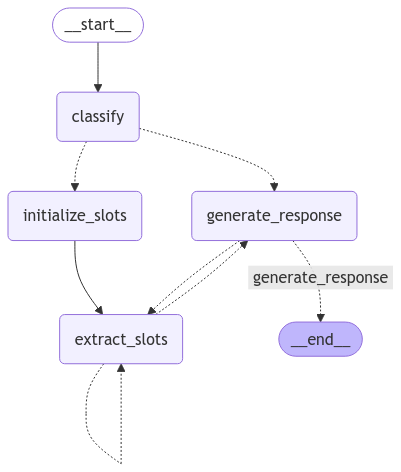

In [19]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

# Visualize the compiled StateGraph as a Mermaid diagram
display(
    Image(
        reservation_agent.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

## Example Execution

Each example demonstrates how the system automatically extracts necessary information and completes the task through natural conversation.


### Restaurant Reservation
  - User: I'd like to make a dinner reservation for 4 people next Friday at 7 PM
  - AI: Could you please specify the restaurant location (city name)?
  - User: New York
  - AI: All information has been entered. I will complete the reservation.

### Hotel Booking
  - User: I want to book a suite room in Manhattan, New York from the 1st to the 3rd of next month
  - AI: Could you please specify the hotel location (city name)?
  - User: New York
  - AI: All information has been entered. I will complete the reservation.

### Meeting Scheduling
  - User: I'm planning to have a one-hour meeting tomorrow at 2 PM in the Downtown conference room
  - AI: Could you please specify the video conference platform (zoom/teams/google meet)?
  - User: Zoom
  - AI: All information has been entered. I will complete the reservation.

### Flight Booking
  - User: I'd like to book 2 economy seats from LAX to New York at 10 AM on the 15th of next month
  - AI: Could you please specify the departure city?
  - User: Los Angeles
  - AI: All information has been entered. I will complete the reservation.



In [20]:
def agent_chat():
    """Runs the interactive reservation system."""
    reservation_agent = create_reservation_agent()

    print("\n=== AI Reservation Assistant ===")
    print("Feel free to discuss your desired reservation or request.")
    print("\n📝 Example Phrases:")
    print("├── Restaurant: " + TASK_EXAMPLES["restaurant"])
    print("├── Hotel: " + TASK_EXAMPLES["hotel"])
    print("├── Meeting Room: " + TASK_EXAMPLES["meeting"])
    print("└── Flight: " + TASK_EXAMPLES["flight"])
    print("\nTo exit, type 'quit' or 'exit'.\n")

    messages_history = []
    task_type = None
    slots = {}

    while True:
        user_input = input("User: ").strip()
        print(f"\nUser: {user_input}")  # Add this line to echo user input

        if user_input.lower() in ["quit", "exit"]:
            print("Exiting reservation system.")
            break

        if not user_input:
            continue

        try:
            messages_history.append(HumanMessage(content=user_input))

            if not task_type:
                state = {
                    "messages": messages_history,
                    "task_type": None,
                    "confidence": 0.0,
                    "slots": {},
                    "current_slot": None,
                    "completed": False,
                    "stage": "classify",
                }

                state = reservation_agent.nodes["classify"].invoke(state)

                if state["confidence"] >= 0.5:
                    task_type = state["task_type"]

                    state = reservation_agent.nodes["initialize_slots"].invoke(state)
                    slots = state["slots"]
                else:
                    print(
                        "Sorry, I couldn't determine which type of reservation you're looking for."
                    )
                    continue

            state = {
                "messages": messages_history,
                "task_type": task_type,
                "confidence": 1.0,
                "slots": slots,
                "current_slot": None,
                "completed": False,
                "stage": "slot_filling",
            }

            state = reservation_agent.nodes["extract_slots"].invoke(state)
            slots = state["slots"]

            state = reservation_agent.nodes["generate_response"].invoke(state)
            if isinstance(state["messages"][-1], AIMessage):
                messages_history.append(state["messages"][-1])

            all_slots_filled = all(
                value is not None and str(value) != "null" and str(value).strip()
                for value in slots.values()
            )

            if all_slots_filled:
                print("\n=== 📝 Conversation Summary ===")
                for msg in messages_history:
                    prefix = "User: " if isinstance(msg, HumanMessage) else "AI: "
                    print(f"{prefix}{msg.content}")

                print("\n=== ✨ Reservation Complete! ✨ ===")
                print(f"Reservation Type: {task_type}")
                for slot, value in slots.items():
                    print(f"{TASK_SLOTS[task_type][slot]}: {value}")
                print("\nTo start a new reservation, feel free to discuss.")
                print("\nTo exit, type 'quit' or 'exit'.\n")

                messages_history = []
                task_type = None
                slots = {}

        except Exception as e:
            print(f"An error occurred: {str(e)}")
            print("Please try again.")
            continue

In [56]:
agent_chat()


=== AI Reservation Assistant ===
Feel free to discuss your desired reservation or request.

📝 Example Phrases:
├── Restaurant: I'd like to make a dinner reservation for 4 people next Friday at 7 PM
├── Hotel: I want to book a suite room in Manhattan, New York from the 1st to the 3rd of next month
├── Meeting Room: I'm planning to have a one-hour meeting tomorrow at 2 PM in the Downtown conference room
└── Flight: I'd like to book 2 economy seats from LAX to New York at 10 AM on the 15th of next month

To exit, type 'quit' or 'exit'.


User: I want to book a suite room in Manhattan, New York from the 1st to the 3rd of next month

=== Task Classification ===
Classified Task: hotel
Confidence: 1.00

=== Initializing Slots ===
Initialized Slots: {'hotel_location': 'null', 'check_in_date': 'null', 'check_out_date': 'null', 'room_type': 'null', 'number_of_guests': 'null'}

=== Extracting Slot Information ===

=== Current Slot Status ===
Task Type: hotel
Hotel Location (City name): New York
